<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_09/05_b_ct_scan_3d_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Step 1: Imports

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


##  Step 2: Simulate 3D CT Scan Dataset

In [13]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rutujapatil2","key":"824684e9eb529f96eb7d30f83bfdf6da"}'}

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

# Download dataset
!kaggle datasets download -d andrewmvd/covid19-ct-scans
!unzip -q covid19-ct-scans.zip -d mosmed

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/covid19-ct-scans
License(s): other


In [15]:
!pip install nibabel

In [16]:
import nibabel as nib
import os
import numpy as np

def load_nifti_file(filepath, target_shape=(64, 64, 64)):
    nii = nib.load(filepath)
    img = nii.get_fdata()
    img = tf.image.resize(img, [target_shape[0], target_shape[1]])
    img = tf.image.resize(tf.transpose(img, perm=[2, 0, 1]), [target_shape[2], target_shape[0]])  # To [D, H, W]
    img = tf.expand_dims(img, axis=-1)  # Shape: [D, H, W, 1]
    return img.numpy().astype(np.float32)

In [18]:
import pandas as pd
meta_df = pd.read_csv("mosmed/metadata.csv")
meta_df.head()


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


## Step 3: Train/Validation/Test Split

In [21]:
import nibabel as nib
import numpy as np

def load_nifti(path, target_shape=(64, 64, 64)):
    img = nib.load(path).get_fdata()
    img = tf.image.resize(img, [target_shape[0], target_shape[1]])
    img = tf.image.resize(tf.transpose(img, perm=[2, 0, 1]), [target_shape[2], target_shape[0]])
    img = tf.expand_dims(img, axis=-1)
    return img.numpy().astype(np.float32)


In [23]:
X = []
y = []

for _, row in meta_df.iterrows():
    ct_path = os.path.join("mosmed/ct_scans", os.path.basename(row['ct_scan']))
    mask_path = os.path.join("mosmed/infection_mask", os.path.basename(row['infection_mask']))

    try:
        volume = load_nifti(ct_path)
        mask = load_nifti(mask_path)

        label = 1 if np.sum(mask) > 0 else 0
        X.append(volume)
        y.append(label)
    except Exception as e:
        print(f"⚠️ Skipped: {ct_path} | Reason: {str(e)}")

X = np.array(X)
y = np.array(y)
print("Loaded:", X.shape, y.shape)


✅ Loaded: (20, 64, 64, 64, 1) (20,)


## Step 4: Build the 3D CNN Model

In [24]:
# Normalize pixel values between 0 and 1
X = X / np.max(X)

# Shuffle
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# Split into train/val/test
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (14, 64, 64, 64, 1), Val: (3, 64, 64, 64, 1), Test: (3, 64, 64, 64, 1)


In [25]:
from tensorflow.keras import layers, models

def build_3d_cnn(input_shape=(64, 64, 64, 1)):
    model = models.Sequential([
        layers.Conv3D(32, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling3D(2),
        layers.Conv3D(64, 3, activation='relu'),
        layers.MaxPooling3D(2),
        layers.Conv3D(128, 3, activation='relu'),
        layers.GlobalAveragePooling3D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model = build_3d_cnn()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 62, 62, 62, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 31, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 29, 29, 29, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 14, 14, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 12, 12, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,889 (1.09 MB)

 Trainable params: 285,889 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

##  Step 5: Compile the Model

In [26]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Step 6: Train the Model

In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=4
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7595 - loss: 0.6534 - val_accuracy: 1.0000 - val_loss: 0.5054
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.2850 - val_accuracy: 1.0000 - val_loss: 0.0548
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 1.1007e-04
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 1.1705e-05 - val_accuracy: 1.0000 - val_loss: 4.2920e-08
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 3.0096e-07 - val_accuracy: 1.0000 - val_loss: 2.2579e-11
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 9.5733e-08 - val_accuracy: 1.0000 - val_loss: 3.6714e-14
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 1.3280e-09 - val_accuracy: 1.0000 - val_loss: 2.2781e-16
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 5.9423e-14 - v

## Step 7: Plot Accuracy and Loss

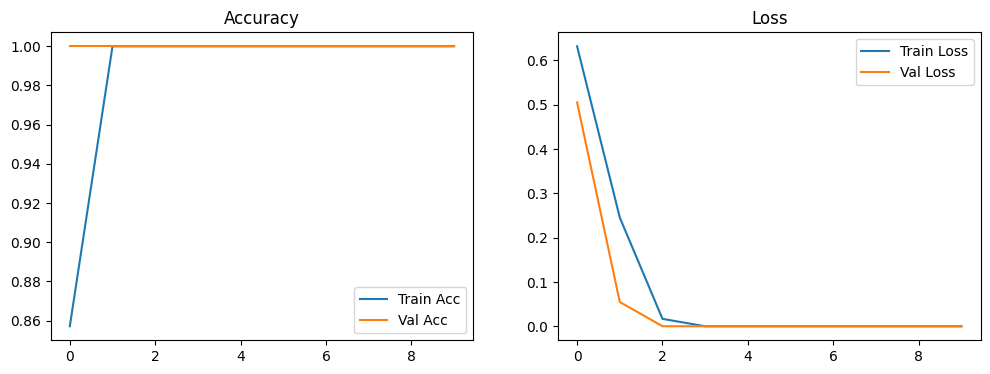

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


## Step 8: Evaluate on Test Set

In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {test_acc:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 7.1994e-21
Final Test Accuracy: 100.00%
